In [414]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor as RFR
from xgboost import XGBRegressor as XGBR
from lightgbm import LGBMRegressor as LGBMR

In [396]:
# Load data

customer_df = pd.read_csv('we_fn_use_c_marketing_customer_value_analysis.csv')

In [397]:
# Rename columns

customer_df.rename(columns=lambda c: c.lower().replace(' ', '_'), inplace=True)
customer_df.rename(columns={'employmentstatus': 'employment_status'}, inplace=True)

In [398]:
# Transform effective_to_date column into week/weekend

def transform_to_week_weekend(cell):
    if cell.dayofweek <= 4:
        return 'week_day'
    return 'weekend'

customer_df['effective_to_date'] = pd.to_datetime(customer_df['effective_to_date']).apply(transform_to_week_weekend)

In [399]:
# Drop customer column

customer_df.drop(columns='customer', axis=1, inplace=True)

In [400]:
# Remove policy type from policy column

customer_df['policy'] = customer_df['policy'].replace(to_replace='\w+ ', value='', regex=True)

In [401]:
# Unify vehicle_class column

def unify_vehicle_class(cell):
    if cell in ['Four-Door Car', 'SUV', 'Luxury SUV', 'Luxury Car']:
        return 'Luxury Car'
    return 'Sports Car'

customer_df['vehicle_class'] = customer_df['vehicle_class'].apply(unify_vehicle_class)

In [402]:
# Unify employment_status column

def unify_employment_status(cell):
    if cell in ['Employed', 'Medical Leave', 'Disabled']:
        return 'Employed'
    return 'Unemployed'

customer_df['employment_status'] = customer_df['employment_status'].apply(unify_employment_status)

In [403]:
# Map categorical columns into int values

def get_mapping(dataframe):
    dictionary = {}
    values = dataframe.unique()
    for idx, val in enumerate(values):
        dictionary.update({val : idx})
    
    return dictionary

ordinal_encoding_columns = ['response', 'coverage', 'employment_status', 'vehicle_size']

for col_name in ordinal_encoding_columns:
    mapping = get_mapping(customer_df[col_name])
    customer_df[col_name] = customer_df[col_name].map(mapping)

In [404]:
# X-y split

X = customer_df.drop(['total_claim_amount'], axis=1)
y = customer_df['total_claim_amount']

In [405]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [406]:
# Select numerical features

numericals_train = X_train.select_dtypes(np.number)
numericals_test = X_test.select_dtypes(np.number)

In [407]:
# Standardize numerical features

transformer = StandardScaler().fit(numericals_train)
numericals_train_standardized = transformer.transform(numericals_train)
numericals_test_standardized = transformer.transform(numericals_test)

In [408]:
# Select categorical features

categoricals_train= X_train.select_dtypes(object)
categoricals_test= X_test.select_dtypes(object)

In [409]:
# One Hot encode categorical features

encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(categoricals_train)
categoricals_train_encoded = encoder.transform(categoricals_train).toarray()
categoricals_test_encoded = encoder.transform(categoricals_test).toarray()

In [410]:
# Concat numerical and categorical features

X_train = np.concatenate((numericals_train_standardized,categoricals_train_encoded),axis=1)
X_test = np.concatenate((numericals_test_standardized,categoricals_test_encoded),axis=1)

In [411]:
# Test linear regression

LR = linear_model.LinearRegression()
LR.fit(X_train,y_train)

train_score=LR.score(X_train, y_train)
test_score=LR.score(X_test, y_test)
print ('Model: {}, train R2: {} -- test R2: {}'.format(LR, train_score, test_score))

Model: LinearRegression(), train R2: 0.7695989919779721 -- test R2: 0.7684686726347569


In [413]:
# Try to detect best n_neighbors for KNeighborsRegressor

train_scores = []
test_scores = []
for k in range(2,25):
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

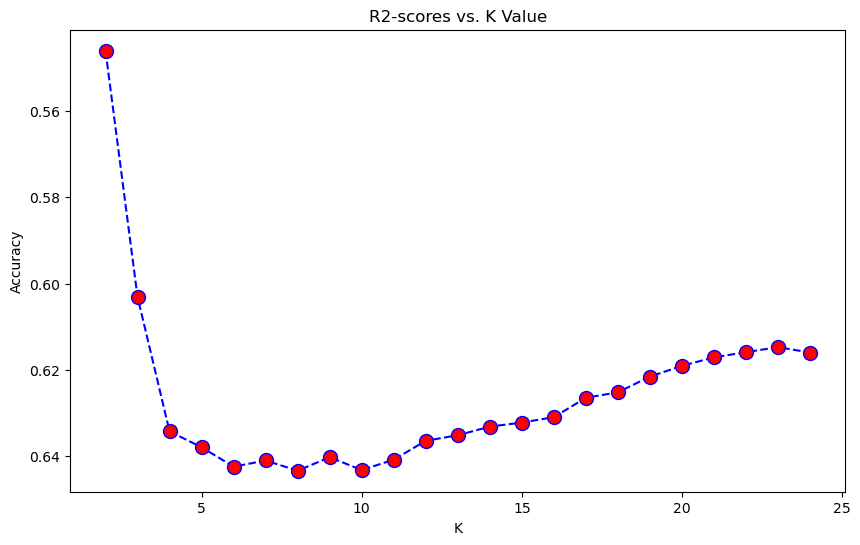

In [415]:
# Plot n_neighbors results for KNeighborsRegressor 

plt.figure(figsize=(10,6))
plt.plot(range(2,25),test_scores,color = 'blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('R2-scores vs. K Value')
plt.gca().invert_yaxis()
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Best n_neighbors for KNeighborsRegressor seems to be 4

In [416]:
def compare_models(models):
    results = {}
    for model in models:
        model.fit(X_train,y_train)
        results.update({
            f'{model}': {
                'train_score' : model.score(X_train, y_train),
                'test_score' : model.score(X_test, y_test)
            }
        })

    return results

models_to_test = [
    linear_model.LinearRegression(),
    KNeighborsRegressor(n_neighbors=4),
    MLPRegressor(),
    Lasso(),
    Ridge(),
    ElasticNet(),
    RFR(),
    XGBR(),
    LGBMR()
]

result = compare_models(models_to_test)
result

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'LinearRegression()': {'train_score': 0.7695989919779721,
  'test_score': 0.7684686726347569},
 'KNeighborsRegressor(n_neighbors=4)': {'train_score': 0.780729703739754,
  'test_score': 0.6342840892323167},
 'MLPRegressor()': {'train_score': 0.8227213102452429,
  'test_score': 0.8252752837022019},
 'Lasso()': {'train_score': 0.7682964915128249,
  'test_score': 0.7677985872126191},
 'Ridge()': {'train_score': 0.7695984236510922,
  'test_score': 0.7684456573584447},
 'ElasticNet()': {'train_score': 0.5880069530196016,
  'test_score': 0.5682823924723173},
 'RandomForestRegressor()': {'train_score': 0.9769577663376562,
  'test_score': 0.8544968523493721},
 "XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n             gamma=0, gpu_id=-1, importance_type=None,\n             interaction_constraints='', learning_rate=0.300000012,\n             max_delta_step=0, max_depth=6, min_child_weight=1, 

In [ ]:
# Formatted values

# 'LinearRegression()': {'train_score': 0.7695989919779721,'test_score': 0.7684686726347569},
# 'KNeighborsRegressor(n_neighbors=4)': {'train_score': 0.780729703739754,'test_score': 0.6342840892323167},
# 'MLPRegressor()': {'train_score': 0.8227213102452429,'test_score': 0.8252752837022019},
# 'Lasso()': {'train_score': 0.7682964915128249,'test_score': 0.7677985872126191},
# 'Ridge()': {'train_score': 0.7695984236510922,'test_score': 0.7684456573584447},
# 'ElasticNet()': {'train_score': 0.5880069530196016,'test_score': 0.5682823924723173},
# 'RandomForestRegressor()': {'train_score': 0.9769577663376562,'test_score': 0.8544968523493721},
# "XGBRegressor()": {'train_score': 0.9680990738349673,'test_score': 0.8421046784673919},
# 'LGBMRegressor()': {'train_score': 0.9124760198162961,'test_score': 0.8523326674871416}

In [ ]:
# It seems that LinearRegression performs better than KNeighborsRegressor here.
# If we take into account the other models, LGBMRegressor gives better results

In [1]:
# Export Dataframe into csv

customer_df.to_csv('marketing_customer_analysis_cleaned.csv')

NameError: name 'customer_df' is not defined